# Bricklayer attack replication & improvement

Original Bricklayer paper:
https://eprint.iacr.org/2017/1021.pdf

## ChaCha QR function:
```
a += b; d ^= a; d <<<= 16;
c += d; b ^= c; b <<<= 12;
a += b; d ^= a; d <<<= 8;
c += d; b ^= c; b <<<= 7;
```

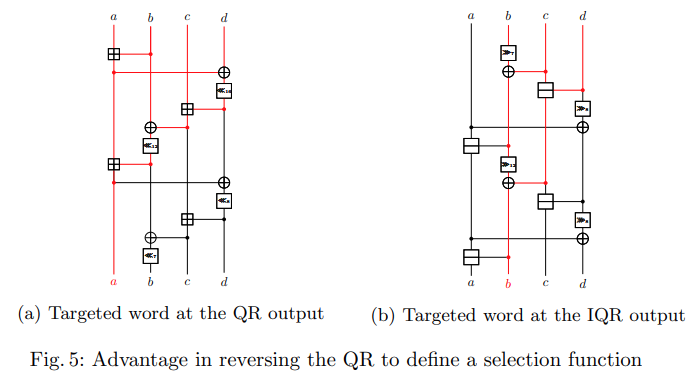

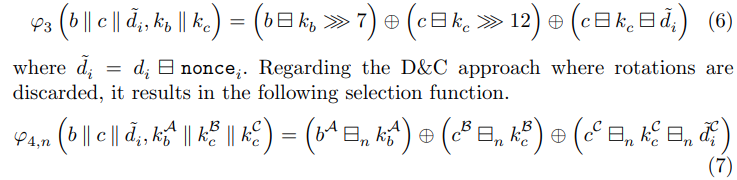

A forward attack (using QR) guesses values of k in B (or B' since they are equal) using correlation after the first column rounds (see "working variable" and "column rounds" in the excerpt below).
A reverse attack (using IQR) guesses values of k in B, recovers B' state in the "final block addition" step and uses correlation in the last "diagonal rounds" step.

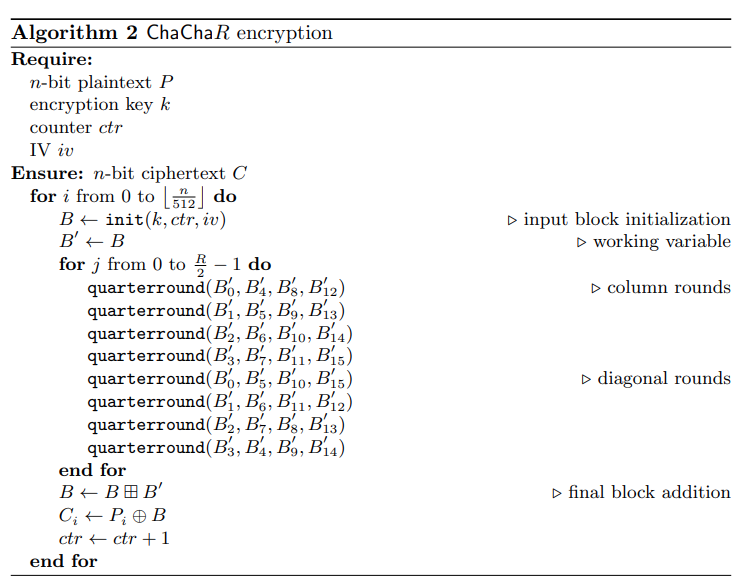

In [ ]:
import enum
import os
import sys

import numpy as np

sys.path.append("../pa-tools")

from patools import CorrelationPowerAnalysis as CPA, CPAModel, CPACollapseMethod, TracesFileProxy
from patools.traces import precompute_difftraces, corr_traces_pre
from patools.utils.plotting import bplotme

import pyximport
pyximport.install(language_level=3, reload_support=True,
                  setup_args={"include_dirs": np.get_include()})
import Bricklayer

In [ ]:
# Select target platform
target_platform = "CW308_STM32F3"

# Select ChaCha implementation ['simplesalsa'|'mbedTLS'|'wolfSSL']
target_impl = 'mbedTLS'

# Select dir containing traces
target_dir = os.path.expanduser(f'~/traces/{target_platform}/{target_impl}')

In [ ]:
# fname_infix depends on the settings used in ChaCha-Gather
fname_infix = '24000000-20000-26328'
# We use two files for this attack:
#  * random key/IV set for initial correlation and finding interesting points
fname_training = f'{target_dir}/chacha-{fname_infix}-random-4k'
#  * challenge key/semi-regular IV/input for the attack phase
fname_challenge = f'{target_dir}/chacha-{fname_infix}-tlslike-4k'

In [ ]:
# Preprocess txis, txos and key, split to words
def split_to_blocks(tracef):
    txis = [[int.from_bytes(txi[i:i+4], 'little') for i in range(0, 16, 4)]
            for txi in tracef.textins]
    txos = [[[int.from_bytes(txo[i+j:i+j+4], 'little') for i in range(0, 16, 4)] for j in range(0, 64, 16)]
            for txo in tracef.textouts]
    keybs = [[int.from_bytes(key[i:i+4], 'little') for i in range(0, 32, 4)]
             for key in tracef.keys]
    return txis, txos, keybs

## Short training - identify Points Of Interest (POIs)
A known random key and nonce are used initially to gather POI training material.

In [ ]:
training_tracef = TracesFileProxy.load(fname_training)
# Parametrize learning target (# of traces and trace slice)
anal_off = 0
anal_len = training_tracef.max_length
anal_cnt = training_tracef.total_count
# anal_off = 1000
# anal_len = 2000
# anal_cnt = 5000
training_traces = training_tracef.traces[:anal_cnt,anal_off:anal_off+anal_len]

In [ ]:
meantrace, difftraces, nvar_trace = precompute_difftraces(training_traces)
txis, txos, keybs = split_to_blocks(training_tracef)
bplotme(meantrace, title="Mean Trace")

In [ ]:
nPOIs = 15

tbPOIs = {}
rs_lst = []
prs_lst = []

def extract_POI_traces(POIs, meantrace, difftraces, nvar_trace):
    nPOIs = len(POIs)
    trcnt = difftraces.shape[0]
    dtype = difftraces.dtype
    POI_meantrace = np.empty(nPOIs, dtype=dtype)
    POI_difftraces = np.empty((trcnt,nPOIs), dtype=dtype)
    POI_nvar_trace = np.empty(nPOIs, dtype=dtype)
    for i, p in enumerate(POIs):
        POI_meantrace[i] = meantrace[p]
        POI_difftraces[:,i] = difftraces[:,p]
        POI_nvar_trace[i] = nvar_trace[p]
    return POI_meantrace, POI_difftraces, POI_nvar_trace

trcnt = difftraces.shape[0]
print(f"Learning POIs from {trcnt} traces.")

for target_block in range(4):
    target_kb = (1 + target_block) % 4
    target_kc = 4 + (2 + target_block) % 4
    hw_phi = Bricklayer.masked_phi_4(32, target_block)
    hws = np.empty(trcnt)
    for i, txi, txo, key in zip(range(trcnt), txis, txos, keybs):
        real_parts = (key[target_kb], key[target_kc], 0xFFFFFFFF, 0xFFFFFFFF)
        hws[i] = hw_phi(real_parts, (txi, txo))
    rs = corr_traces_pre(hws, difftraces, nvar_trace)
    rs_lst.append(rs)
    
    POIs = []
    ars = np.abs(rs)
    srs = np.sign(rs)
    for _ in range(nPOIs):
        # Find the biggest peak and add it to the list of POIs
        nextPOI = ars.argmax()
        POIs.append(nextPOI)
        ars[nextPOI] = 0
    POIs.sort()
    print(POIs)
    POIsigns = [srs[i] for i in POIs]
    POI_meantrace, POI_difftraces, POI_nvar_trace = extract_POI_traces(POIs, meantrace, difftraces, nvar_trace)
    prs = corr_traces_pre(hws, POI_difftraces, POI_nvar_trace)
    prs_lst.append(prs)
    
    tbPOIs[target_block] = (POIs, POIsigns)

bplotme(*rs_lst, title="Point correlations (pre POIs)")
bplotme(*prs_lst, title="Point correlations (on POIs)")

In [ ]:
class PhiModel(enum.Enum):
    PHI_3_RANDOM = 0  # Model mimicking phi_3 (from Bricklayer paper), which averages unknown
                      # key bits over 2048 pseudorandom candidates, i.e. unknown key bits are
                      # replaced by random bits and hypothesis HW is averaged.
    PHI_4 = 1         # Model identical to phi_4 in the original Bricklayer paper
    
    def get_function(self, width, block):
        if self is self.PHI_3_RANDOM:
            return Bricklayer.random_masked_phi_3(block)
        if self is self.PHI_4:
            return Bricklayer.masked_phi_4(width, block)
        raise NotImplementedError()


phi_model = PhiModel.PHI_4
print_limit = 16
model = CPAModel.SIG
best_reduce = CPACollapseMethod.AVG

In [ ]:
def cutoff_point(ris, cutoff_pts, eps_pc):
    """
    Select cutoff point to select cutoff_pts and then lower it by eps_pc.
    eps_pc is relative to (max - min) ris values
    E.g. for cutoff_pts=4 and eps_pc=0.1 if the fourth highest points in ris are 0.5, and the lowest is 0.1
    cutoff_point returns 0.5 - ((0.5 - 0.1) * eps_pc)
    """
    scale = ris[0][1][0] - ris[-1][1][0]
    return ris[cutoff_pts - 1][1][0] - scale * eps_pc

def search_candidates(target_kb, target_kc, ncandidates, hw_phi, difftraces, nvar_trace,
                      corrsigns, no_candidates, eps):
    inputs = list(zip(txis, txos))[:atk_cnt]
    ris = CPA.single(hw_phi, difftraces, nvar_trace, inputs, ncandidates,
                     plot_ris=True,
                     model=model,
                     corr_signs=corrsigns,
                     best_reduce=best_reduce)
    
    # Read cutoff from the last plot and set it here:
    cutoff = cutoff_point(ris, no_candidates, eps)
    candidates = []
    pl = print_limit
    for k, v in ris:
        if v[0] < cutoff:
            break
        candidates.append(k)            
        kb, kc, kb_mask, kc_mask = k
        r = (keybs[target_kb] & kb_mask), (keybs[target_kc] & kc_mask)
        if pl > 0:
            pl -= 1
            print(' '.join(f'{p:08x}' for p in k), ':', ' '.join(f'{p:08x}' for p in r), f': {v}',
                  "!" if keybs[target_kb] & k[2] == k[0] else " ",
                  "@" if keybs[target_kc] & k[3] == k[1] else " ")
    if print_limit < len(candidates):
        print("...")
    print(f"Cutoff {cutoff} selected {len(candidates)} out of {len(ris)} candidates.")
    for i, (k, v) in enumerate(ris):
        kb, kc, kb_mask, kc_mask = k
        r = (keybs[target_kb] & kb_mask), (keybs[target_kc] & kc_mask)
        if r == (kb, kc):
            print(f"Correct was a candidate at rank {i}/{len(ris)} with weight: {v}")
            break
    return candidates

In [ ]:
attack_tracef = TracesFileProxy.load(fname_challenge)
# Parametrize attack target (# of traces and trace slice, slice must align with the one chosen for computing POIs)
atk_off = anal_off
atk_len = anal_len
# atk_cnt = attack_tracef.total_count
atk_cnt = 1500

attack_traces = attack_tracef.traces[:atk_cnt,atk_off:atk_off+atk_len]
txis, txos, keybs = split_to_blocks(attack_tracef)
# All attack traces have the same key
keybs = keybs[0]

In [ ]:
meantrace, difftraces, nvar_trace = precompute_difftraces(attack_traces)

## Attack 1: +/- original Bricklayer (12-bit bricks)

Attacks 4-bit wide bricks as shown in the original Bricklayer paper.
Selects only a minimal amounts of colliding values (4, later 2 and finally only 1), plus a proportional margin.

In [ ]:
def attack_block(target_block, _meantrace, difftraces, nvar_trace, corrsigns):
    """
    Attacks 4-bit wide bricks as shown in the original Bricklayer paper.
    Selects only a minimal amounts of colliding values, plus a proportional margin.
    """
    target_kb = (1 + target_block) % 4
    target_kc = 4 + (2 + target_block) % 4
    
    m = 4
    ncandidates = [Bricklayer.masked_phi_key_split(m, kg)
                   for kg in range(1 << (3*m))]
    candidates = search_candidates(target_kb, target_kc, ncandidates, phi_model.get_function(m, target_block), 
                                   difftraces, nvar_trace, corrsigns, 4, 0.1)
    
    n = m
    m = 8
    ncandidates = [Bricklayer.masked_phi_key_grow(n, m, k, parts)
                   for parts in candidates
                   for k in range(1 << (3*(m-n)))]
    candidates = search_candidates(target_kb, target_kc, ncandidates, phi_model.get_function(m, target_block), 
                                   difftraces, nvar_trace, corrsigns, 4, 0.1)
    
    n = m
    m = 12
    ncandidates = [Bricklayer.masked_phi_key_grow(n, m, k, parts)
                   for parts in candidates
                   for k in range(1 << (3*(m-n)))]
    candidates = search_candidates(target_kb, target_kc, ncandidates, phi_model.get_function(m, target_block), 
                                   difftraces, nvar_trace, corrsigns, 4, 0.1)
    
    n = m
    m = 16
    # at m>12, we stop growing kc_c part as it would cross with kc_b
    ncandidates = [Bricklayer.masked_phi_key_grow2(n, m, k, parts)
                   for parts in candidates
                   for k in range(1 << (2*(m-n)))]
    candidates = search_candidates(target_kb, target_kc, ncandidates, phi_model.get_function(m, target_block), 
                                   difftraces, nvar_trace, corrsigns, 2, 0.1)
    
    n = m
    m = 20
    # at m>12, we stop growing kc_c part as it would cross with kc_b
    ncandidates = [Bricklayer.masked_phi_key_grow2(n, m, k, parts)
                   for parts in candidates
                   for k in range(1 << (2*(m-n)))]
    candidates = search_candidates(target_kb, target_kc, ncandidates, phi_model.get_function(m, target_block), 
                                   difftraces, nvar_trace, corrsigns, 1, 0.1)
    
    n = m
    m = 32
    # at m>20, we stop growing kc
    ncandidates = [Bricklayer.masked_phi_key_grow3(n, m, k, parts)
                   for parts in candidates
                   for k in range(1 << (m-n))]
    candidates = search_candidates(target_kb, target_kc, ncandidates, phi_model.get_function(m, target_block), 
                                   difftraces, nvar_trace, corrsigns, 1, 0.1)
    
    return candidates

In [ ]:
POIs, POIsigns = tbPOIs[0]
candidates_0 = attack_block(0, *extract_POI_traces(POIs, meantrace, difftraces, nvar_trace), POIsigns)

In [ ]:
POIs, POIsigns = tbPOIs[1]
candidates_1 = attack_block(1, *extract_POI_traces(POIs, meantrace, difftraces, nvar_trace), POIsigns)

In [ ]:
POIs, POIsigns = tbPOIs[2]
candidates_2 = attack_block(2, *extract_POI_traces(POIs, meantrace, difftraces, nvar_trace), POIsigns)

In [ ]:
POIs, POIsigns = tbPOIs[3]
candidates_3 = attack_block(3, *extract_POI_traces(POIs, meantrace, difftraces, nvar_trace), POIsigns)

In [ ]:
total_cases = len(candidates_0) * len(candidates_1) * len(candidates_2) * len(candidates_3)
print("Total cases for the final exhaustive search:", total_cases)

## Attack 2: Smallbricks variant (custom), (3/2/1-bit bricks)

Attacks an initial 4-bit brick and then grows it progressively by 1 bit in each round,
but taking a significant chunk of candidates after each round (64 candidates + 10% or later 5% of proportional weight).

In [ ]:
def attack_smallbricks(target_block, _meantrace, difftraces, nvar_trace, corrsigns):
    """
    Attacks an initial 4-bit brick and then grows it progressively by 1 bit in each round,
    but taking a significant chunk of candidates after each round.
    """
    target_kb = (1 + target_block) % 4
    target_kc = 4 + (2 + target_block) % 4
    
    m = 4
    ncandidates = [Bricklayer.masked_phi_key_split(m, kg)
                   for kg in range(1 << (3*m))]
    while True:
        candi_select = (64, 0.1) if m <= 12 else \
                       (64, 0.05) if m <= 20 else \
                       (64, 0.05)
        candidates = search_candidates(target_kb, target_kc, ncandidates, phi_model.get_function(m, target_block),
                                       difftraces, nvar_trace, corrsigns, *candi_select)
        n = m
        m += 1
        if m > 32:
            return candidates
        # at m>12, we stop growing kc_c part as it would cross with kc_b
        # at m>20, we stop growing kc
        layer_fun = Bricklayer.masked_phi_key_grow if m <= 12 else \
                    Bricklayer.masked_phi_key_grow2 if m <= 20 else \
                    Bricklayer.masked_phi_key_grow3
        layer_grow = 3 if m <= 12 else \
                     2 if m <= 20 else \
                     1
        ncandidates = [layer_fun(n, m, k, parts)
                       for parts in candidates
                       for k in range(1 << layer_grow)]

In [ ]:
POIs, POIsigns = tbPOIs[0]
candidates_0 = attack_smallbricks(0, *extract_POI_traces(POIs, meantrace, difftraces, nvar_trace), POIsigns)

In [ ]:
POIs, POIsigns = tbPOIs[1]
candidates_1 = attack_smallbricks(1, *extract_POI_traces(POIs, meantrace, difftraces, nvar_trace), POIsigns)

In [ ]:
POIs, POIsigns = tbPOIs[2]
candidates_2 = attack_smallbricks(2, *extract_POI_traces(POIs, meantrace, difftraces, nvar_trace), POIsigns)

In [ ]:
POIs, POIsigns = tbPOIs[3]
candidates_3 = attack_smallbricks(3, *extract_POI_traces(POIs, meantrace, difftraces, nvar_trace), POIsigns)

In [ ]:
total_cases = len(candidates_0) * len(candidates_1) * len(candidates_2) * len(candidates_3)
print("Total cases for the final exhaustive search:", total_cases)

## Attack 3: +/- original Bricklayer (5/15-bit bricks)

Attacks 5-bit wide bricks for an improved correlation target.
Selects only a minimal amounts of colliding values (4, later 2 and finally only 1), plus a proportional margin.

In [ ]:
def attack_block(target_block, _meantrace, difftraces, nvar_trace, corrsigns):
    """
    Attacks 5-bit wide bricks, since 2^15 is still within acceptable CPA target,
    and larger bricks provide better correlation.
    Selects only a minimal amounts of colliding values, plus a proportional margin.
    """
    target_kb = (1 + target_block) % 4
    target_kc = 4 + (2 + target_block) % 4
    
    m = 5
    ncandidates = [Bricklayer.masked_phi_key_split(m, kg)
                   for kg in range(1 << (3*m))]
    candidates = search_candidates(target_kb, target_kc, ncandidates, phi_model.get_function(m, target_block), 
                                   difftraces, nvar_trace, corrsigns, 4, 0.1)
    
    n = m
    m = 10
    ncandidates = [Bricklayer.masked_phi_key_grow(n, m, k, parts)
                   for parts in candidates
                   for k in range(1 << (3*(m-n)))]
    candidates = search_candidates(target_kb, target_kc, ncandidates, phi_model.get_function(m, target_block), 
                                   difftraces, nvar_trace, corrsigns, 4, 0.1)
    
    n = m
    m = 12
    tcandidates = [Bricklayer.masked_phi_key_grow(n, m, k, parts)
                   for parts in candidates
                   for k in range(1 << (3*(m-n)))]
    n = m
    m = 15
    # at m>12, we stop growing kc_c part as it would cross with kc_b
    ncandidates = [Bricklayer.masked_phi_key_grow2(n, m, k, parts)
                   for parts in tcandidates
                   for k in range(1 << (2*(m-n)))]
    candidates = search_candidates(target_kb, target_kc, ncandidates, phi_model.get_function(m, target_block), 
                                   difftraces, nvar_trace, corrsigns, 2, 0.1)
    
    
    n = m
    m = 20
    # at m>12, we stop growing kc_c part as it would cross with kc_b
    ncandidates = [Bricklayer.masked_phi_key_grow2(n, m, k, parts)
                   for parts in candidates
                   for k in range(1 << (2*(m-n)))]
    candidates = search_candidates(target_kb, target_kc, ncandidates, phi_model.get_function(m, target_block), 
                                   difftraces, nvar_trace, corrsigns, 1, 0.1)
    
    n = m
    m = 32
    # at m>20, we stop growing kc
    ncandidates = [Bricklayer.masked_phi_key_grow3(n, m, k, parts)
                   for parts in candidates
                   for k in range(1 << (m-n))]
    candidates = search_candidates(target_kb, target_kc, ncandidates, phi_model.get_function(m, target_block), 
                                   difftraces, nvar_trace, corrsigns, 1, 0.1)
    
    return candidates

In [ ]:
POIs, POIsigns = tbPOIs[0]
candidates_0 = attack_block(0, *extract_POI_traces(POIs, meantrace, difftraces, nvar_trace), POIsigns)

In [ ]:
POIs, POIsigns = tbPOIs[1]
candidates_1 = attack_block(1, *extract_POI_traces(POIs, meantrace, difftraces, nvar_trace), POIsigns)

In [ ]:
POIs, POIsigns = tbPOIs[2]
candidates_2 = attack_block(2, *extract_POI_traces(POIs, meantrace, difftraces, nvar_trace), POIsigns)

In [ ]:
POIs, POIsigns = tbPOIs[3]
candidates_3 = attack_block(3, *extract_POI_traces(POIs, meantrace, difftraces, nvar_trace), POIsigns)

In [ ]:
total_cases = len(candidates_0) * len(candidates_1) * len(candidates_2) * len(candidates_3)
print("Total cases for the final exhaustive search:", total_cases)

## Attack 4: +/- original Bricklayer (8/24-bit bricks)

Attacks 8-bit wide bricks as shown in the original Bricklayer paper.
Selects only a minimal amounts of colliding values (4, later 2 and finally only 1), plus a proportional margin.

In [ ]:
def attack_block(target_block, _meantrace, difftraces, nvar_trace, corrsigns):
    """
    Attacks 8-bit wide bricks (may be costly when compared to Attacks 1-3, but provides the best correlation from the get-go).
    Selects only a minimal amounts of colliding values, plus a proportional margin.
    """
    target_kb = (1 + target_block) % 4
    target_kc = 4 + (2 + target_block) % 4
    
    m = 8
    ncandidates = [Bricklayer.masked_phi_key_split(m, kg)
                   for kg in range(1 << (3*m))]
    candidates = search_candidates(target_kb, target_kc, ncandidates, phi_model.get_function(m, target_block), 
                                   difftraces, nvar_trace, corrsigns, 4, 0.1)
    
    n = m
    m = 12
    tcandidates = [Bricklayer.masked_phi_key_grow(n, m, k, parts)
                   for parts in candidates
                   for k in range(1 << (3*(m-n)))]
    n = m
    m = 16
    # at m>12, we stop growing kc_c part as it would cross with kc_b
    ncandidates = [Bricklayer.masked_phi_key_grow2(n, m, k, parts)
                   for parts in tcandidates
                   for k in range(1 << (2*(m-n)))]
    candidates = search_candidates(target_kb, target_kc, ncandidates, phi_model.get_function(m, target_block), 
                                   difftraces, nvar_trace, corrsigns, 2, 0.1)
    
    
    n = m
    m = 20
    # at m>12, we stop growing kc_c part as it would cross with kc_b
    tcandidates = [Bricklayer.masked_phi_key_grow2(n, m, k, parts)
                   for parts in candidates
                   for k in range(1 << (2*(m-n)))]
    n = m
    m = 24
    # at m>20, we stop growing kc
    ncandidates = [Bricklayer.masked_phi_key_grow3(n, m, k, parts)
                   for parts in tcandidates
                   for k in range(1 << (m-n))]
    candidates = search_candidates(target_kb, target_kc, ncandidates, phi_model.get_function(m, target_block), 
                                   difftraces, nvar_trace, corrsigns, 1, 0.1)
    
    n = m
    m = 32
    # at m>20, we stop growing kc
    ncandidates = [Bricklayer.masked_phi_key_grow3(n, m, k, parts)
                   for parts in candidates
                   for k in range(1 << (m-n))]
    candidates = search_candidates(target_kb, target_kc, ncandidates, phi_model.get_function(m, target_block), 
                                   difftraces, nvar_trace, corrsigns, 1, 0.1)
    
    return candidates

In [ ]:
POIs, POIsigns = tbPOIs[0]
candidates_0 = attack_block(0, *extract_POI_traces(POIs, meantrace, difftraces, nvar_trace), POIsigns)

In [ ]:
POIs, POIsigns = tbPOIs[1]
candidates_1 = attack_block(1, *extract_POI_traces(POIs, meantrace, difftraces, nvar_trace), POIsigns)

In [ ]:
POIs, POIsigns = tbPOIs[2]
candidates_2 = attack_block(2, *extract_POI_traces(POIs, meantrace, difftraces, nvar_trace), POIsigns)

In [ ]:
POIs, POIsigns = tbPOIs[3]
candidates_3 = attack_block(3, *extract_POI_traces(POIs, meantrace, difftraces, nvar_trace), POIsigns)

In [ ]:
total_cases = len(candidates_0) * len(candidates_1) * len(candidates_2) * len(candidates_3)
print("Total cases for the final exhaustive search:", total_cases)

### Legal

The code is published under MIT license (SPDX-License-Identifier: MIT), see [LICENSE](../LICENSE).
The project has been cofounded by Polish National Centre for Research and Development (NCBR) under project "Evaluation of Side Channel Attack Potential on Embedded Targets (ESCAPE)", proj. sign. PL-TW/VII/5/2020.